## Importing required modules and functions, and loading data

In [1]:
import os
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
features = "/scratch/project_2001325/evo_hyperspectral/data/matched_w_features/features.parquet"
field_data_filt = "/scratch/project_2001325/evo_hyperspectral/data/field_data/dbh_over_150mm.shp"
field_data_orig = "/scratch/project_2001325/evo_hyperspectral/data/field_data/all_trees_w_deadwood.shp"

features = gpd.read_parquet(features)
field_data_filt = gpd.read_file(field_data_filt)
field_data_orig = gpd.read_file(field_data_orig)

## Overall and species-specific detection rates

Let's first inspect the overall and species-specific detection rates. The extracted individual tree segments were matched with only the reference trees with a DBH over 150 mm that did not belong to the "Other" species class. However, the detection rates presented below show:

1. The detection rates when compared against all field-measured trees.
2. The detection rates when only compared against the field-measured trees with a DBH over 150 mm and not belonging to the species class "Other".

Based on the computed detection rates, it is rather evident that on multiple occasions, a single reference tree was matched with multiple tree segments. This is due to the matching procedure that did not remove a reference tree from consideration after matching it with a crown segment. 

In [3]:
def compute_detection_rates(refs, segs = features):
    """Prints the overall and species-detection rates using the provided reference and segment instances."""
    print(f'Overall detection rate: {segs.shape[0] / refs.shape[0]}')
    for s in refs.species.unique():
        print(f'{s}: {sum(segs.species == s) / sum(refs.species == s)}')

print("Detection rates including all field-measured trees:")
compute_detection_rates(field_data_orig)

print("\nDetection rates including only trees with a DBH over 150 mm:")
compute_detection_rates(field_data_filt)

Detection rates including all field-measured trees:
Overall detection rate: 0.6312246765128742
Scots pine: 0.9319745222929936
Norway spruce: 0.42685535626131316
Birch: 0.4652348993288591
Other: 0.0
European aspen: 1.674364896073903
deadwood: 0.9218106995884774

Detection rates including only trees with a DBH over 150 mm:
Overall detection rate: 1.4119280806899577
Scots pine: 1.4233463035019456
Norway spruce: 1.2684596577017115
Birch: 1.3677979479084452
European aspen: 2.0223152022315203
deadwood: 0.9256198347107438


### Splitting the data into training and test sets

For further processing and exploration, we split the matched tree segments into training and test sets based on the column of the hyperspectral tile within which the segment is located. We choose tile columns 5, 6, 11, and 12 as the test set, as these columns contain a sufficient number of instances of all tree species.

In [4]:
# Split the tile columns into training and test columns
test_rows = features.tile_id.str.contains("C(5|6|11|12)$")
test_data = features[test_rows]
train_data = features[~test_rows]

# Compute the proportion of test trees
num_train_trees = len(train_data)
num_test_trees = len(test_data)
print(f'The proportion of test trees: {num_test_trees/(num_test_trees + num_train_trees)}')

for s in features.species.unique():
    num_train = sum(train_data.species == s)
    num_test = sum(test_data.species == s)
    print(f'The proportion of {s} instances in the test set: {num_test/(num_test + num_train)}')


The proportion of test trees: 0.13748835283155605
The proportion of Norway spruce instances in the test set: 0.1094834232845027
The proportion of Birch instances in the test set: 0.10848240046162723
The proportion of Scots pine instances in the test set: 0.1440677966101695
The proportion of European aspen instances in the test set: 0.19379310344827586
The proportion of deadwood instances in the test set: 0.21428571428571427


/tmp/heinarei/19243654/ipykernel_220764/927728333.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  test_rows = features.tile_id.str.contains("C(5|6|11|12)$")


Some observations have missing values. We'll replace these with the mean feature values in the training dataset.

In [5]:
means = train_data.iloc[:,20:].mean()
train_data.iloc[:,20:] = train_data.iloc[:,20:].fillna(means)
test_data.iloc[:,20:] = test_data.iloc[:,20:].fillna(means)

We'll store the training and test sets into separate files to ease further processing

In [6]:
#train_data.to_parquet("./data/matched_w_features/train_data.parquet", index = True)
#test_data.to_parquet("./data/matched_w_features/test_data.parquet", index = True)

## Inspecting the features for each species class

Next, we'll inspect how the computed spectral and height-related features differ between each tree species. Before this, however, we first determine the mean wavelength of each spectral channel based on the information provided in the section 2.2 of Mäyrä et al. (2021) (https://doi.org/10.1016/j.rse.2021.112322).

In [6]:
# Compute the center wavelength of each hyperspectral channel. The last channel is the CHM, so we will set its wavelength to nan.
VNIR = np.linspace(406,995,187)
VNIR = np.mean(np.vstack([VNIR[1:], VNIR[:-1]]), axis = 0)
SWIR = np.linspace(956,2525,289)
SWIR = np.mean(np.vstack([SWIR[1:], SWIR[:-1]]), axis = 0)[:274]
wavelengths = np.hstack([VNIR,SWIR,np.nan])

### Channel-wise mean feature values

The plots below present channel-wise mean feature values for each feature type. 

Based on the plots below, we can observe the following:
- Birch and aspen have the largest mean pixel values at both VNIR and SWIR wavelengths
- Deadwood has the smallest mean pixel values at the VNIR range, whereas spruce has the smallest mean pixel values at the SWIR range
- Birch has the largest standard deviation of pixel values. This is especially evident at the VNIR range
- Birch and aspen have both the largest and smallest values.
- The skewness and kurtosis features for the low VNIR channels and high SWIR channels are noisy.

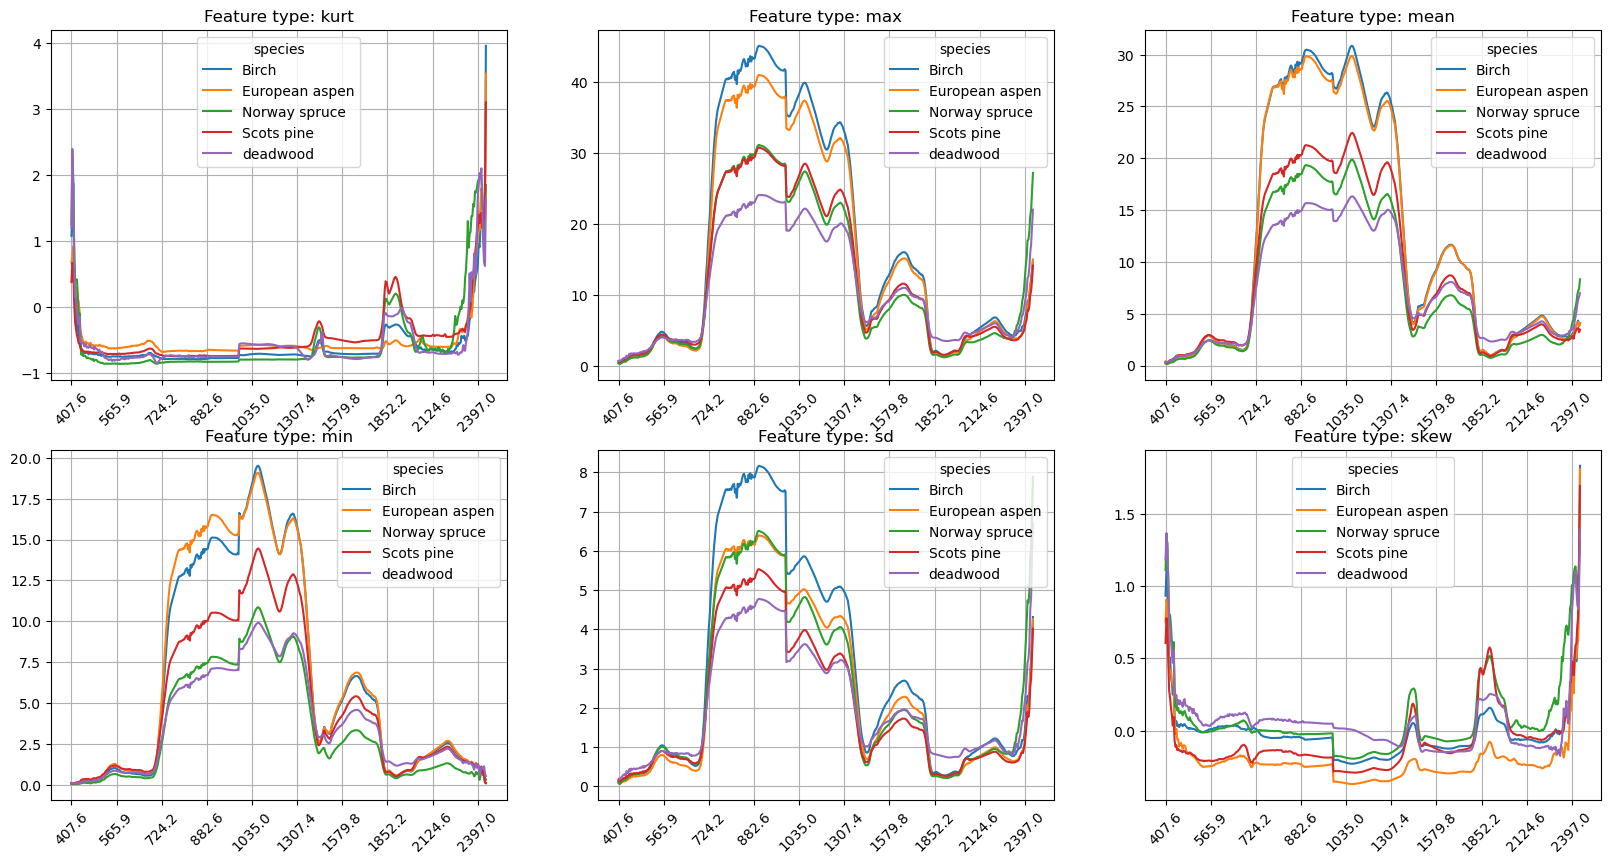

In [7]:
# Separate the features from the other info
info = train_data.iloc[:,:20]
features = train_data.iloc[:,20:]

# Compute species-specific feature means
mean_features = features.groupby(info.species).mean()

# Extract feature types (min, max,...)
feature_types = np.unique([re.search('(.+)_band',colname).group(1) for colname in mean_features.columns])

# Plot the species-specific mean feature values for each feature type (Excluding the CHM channel)
f,ax = plt.subplots(2,3, figsize = (20,10))
ax = ax.flatten()
for i,ftype in enumerate(feature_types):
    df = mean_features.filter(like = ftype)
    df.iloc[:,:-1].T.plot(ax = ax[i]) # Exlude the CHM channel
    ax[i].grid(True)
    ax[i].set_xticks(np.arange(0,df.shape[1],50))
    ax[i].set_xticklabels(np.round(wavelengths[0::50],decimals = 1),rotation = 45)
    ax[i].set_title(f"Feature type: {ftype}")
    
    

### Univariate feature importance

Next, we'll estimate feature importance by using the ANOVA f-statistic for each feature, and computing the channel-wise and feature type wise means of the f-statistic. 

Based on the plots below, we can observe the following:

- The channels in the middle wavelength region seem to have the most discriminative power.
- The kurtosis and skewness features have the least discriminative power.

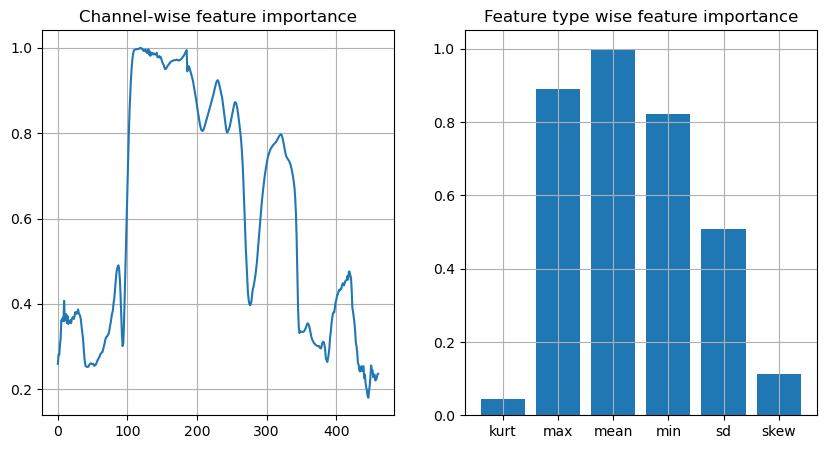

In [8]:
F, _ = f_classif(features, info.species)

# Channel-wise importance
channels = np.unique([int(re.search("[0-9]+",col).group(0)) for col in features.columns])
mean_F = np.zeros(len(channels))
for channel in channels:
    idx = [i for i,colname in enumerate(features.columns) if re.search(f"_{channel}$",colname)]
    F_sub = F[idx]
    mean_F[channel-1] = np.mean(F_sub)

scores = mean_F / mean_F.max()

f, ax = plt.subplots(1,2, figsize = (10,5))
ax[0].plot(np.arange(len(scores)), scores)
ax[0].grid(True)
ax[0].set_title("Channel-wise feature importance")

# Feature type wise importance
feature_types = np.unique([re.search('(.+)_band',colname).group(1) for colname in features.columns])
mean_F = np.zeros(len(feature_types))
for i,f_type in enumerate(feature_types):
    idx = [i for i,colname in enumerate(features.columns) if re.search(f_type,colname)]
    F_sub = F[idx]
    mean_F[i] = np.mean(F_sub)

scores = mean_F / mean_F.max()

ax[1].bar(np.arange(len(scores)), scores)
ax[1].grid(True)
ax[1].set_title("Feature type wise feature importance")
ax[1].set_xticks(np.arange(len(scores)))
ax[1].set_xticklabels(feature_types)
plt.show()

### Principal component analysis

The plot below shows a histogram of correlations between feature-pairs. We see that there are relatively many highly correlated feature pairs. Thus, we will perform PCA to see how much the dimensionality of the data can be reduced without losing much information. PCA is affected by the different scale of features, and thus we will first normalize the features before applying PCA.

We see that the first 100 principal components explain approximately 99% of the variance in the data.

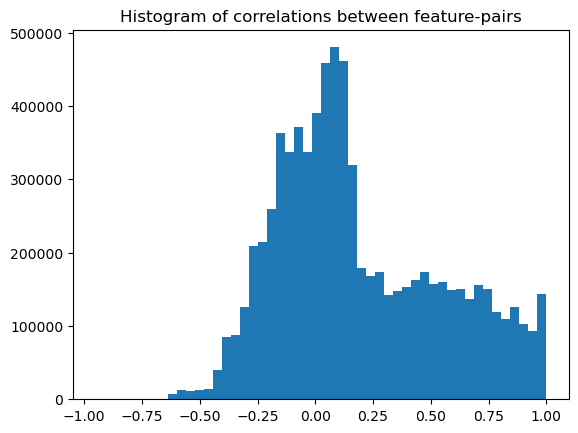

In [9]:
corrs = np.corrcoef(features,rowvar = False).flatten()
plt.hist(corrs, bins = 50)
plt.title("Histogram of correlations between feature-pairs")
plt.show()

In [15]:
# Normalize the data and apply PCA
features_norm = StandardScaler().fit_transform(features)
pca = PCA()
pca.fit(features_norm)

PCA()

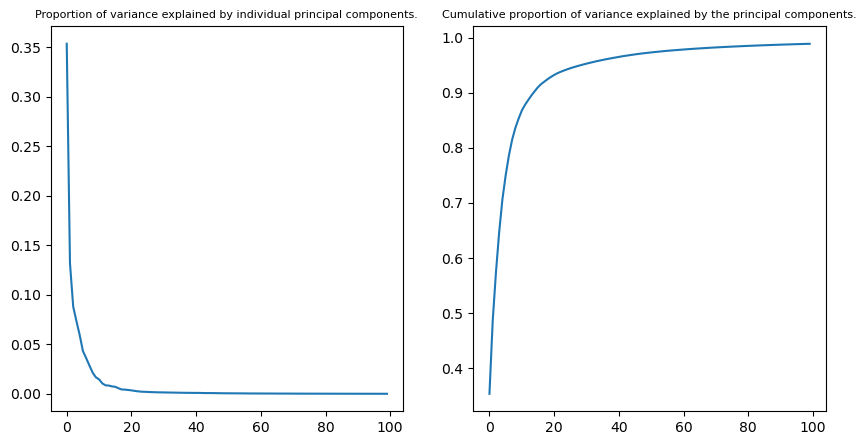

The first 100 principal components explain 98.90% of the variance.


In [45]:
# Plot the proportion and cumulative proportion of variance explained by the principal components
f,ax = plt.subplots(1,2,figsize = (10,5))
ax[0].plot(pca.explained_variance_ratio_[:100])
ax[0].set_title("Proportion of variance explained by individual principal components.", fontsize = 8)

ax[1].plot(np.cumsum(pca.explained_variance_ratio_[:100]))
ax[1].set_title("Cumulative proportion of variance explained by the principal components.", fontsize = 8)

plt.show()

print("The first 100 principal components explain {:.2f}% of the variance.".format(np.cumsum(pca.explained_variance_ratio_[:100])[-1]*100))